Written by: kvikas@, vipular@, alifaraz@

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
def generate_2d_data(batch_size=1000):
    rng = np.random.RandomState()
        
    scale = 4.
    centers = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    centers = [(scale * x, scale * y) for x, y in centers]

    dataset = []
    for i in range(batch_size):
        point = rng.randn(2) * 0.5   #According to me, 0.5 should not be there.
        idx = rng.randint(4)
        center = centers[idx]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)
    dataset = np.array(dataset, dtype="float32")
    dataset /= 1.414                #According to me, this line should not be there.
    return dataset

In [ ]:
def plot_samples_2d(data, name=None):
    plt.figure(figsize=(5,5))
    plt.xlim([-5, 5])
    plt.ylim([-5, 5])
    plt.scatter(data[:, 0], data[:, 1]) 
    
    if name:
        plt.savefig('./demo/%s'%(name) + ".png", format="png")

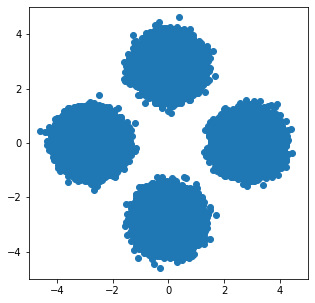

In [ ]:
data=generate_2d_data(1000000)
plot_samples_2d(data)

**Note:** We just have the samples, no $p^*_x(x)$.

Let us create the input distribution $p_u(u)$

In [ ]:
import tensorflow_probability as tfp
base_dist = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros([2])) #, tf.float32))

In [ ]:
class NN(layers.Layer):
    """
    Neural Network Architecture for calcualting s and t for Real-NVP
    
    :param input_shape: shape of the data coming in the layer
    :param hidden_units: Python list-like of non-negative integers, specifying the number of units in each hidden layer.
    :param activation: Activation of the hidden units
    """
    def __init__(self, input_shape, n_hidden=[64,64], activation="relu"):
        super(NN, self).__init__(name="nn")
        layer_list = []
        for n in n_hidden:
            layer_list.append(layers.Dense(n, activation=activation))
        self.layer_list = layer_list
        self.log_s_layer = layers.Dense(input_shape, activation="tanh", name='log_s')
        self.t_layer = layers.Dense(input_shape, name='t')

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t

In [ ]:
class RealNVP:
    """
    Implementation of a Real-NVP for Density Estimation. L. Dinh “Density estimation using Real NVP,” 2016.
    This implementation only works for 1D arrays.
    :param input_shape: shape of the data coming in the layer
    :param hidden_units: Python list-like of non-negative integers, specifying the number of units in each hidden layer.
    """

    def __init__(self, input_shape, flip):
        assert input_shape % 2 == 0
        input_shape = input_shape // 2
        nn = NN(input_shape)
        x = keras.Input(input_shape)
        log_s, t = nn(x)
        self.nn = keras.Model(x, [log_s, t], name="nn")
        self.flip = flip
        #print(self.nn.summary())
        
    def _forward(self, u):
        u1, u2 = tf.split(u, 2, axis=-1)

        if self.flip == True:
          u1, u2 = u2, u1

        x1 = u1
        log_s, mu = self.nn(u1)
        x2 = u2 * tf.exp(log_s) + mu 

        if self.flip == True:
          x1, x2 = x2, x1
        
        x = tf.concat([x1, x2], axis=-1)
        return x, log_s

    def _inverse(self, x):
        x1, x2 = tf.split(x, 2, axis=-1)

        if self.flip == True:
          x1, x2 = x2, x1
        
        u1 = x1
        log_s, mu = self.nn(x1)
        u2 = (x2 - mu)/tf.exp(log_s)

        if self.flip == True:
          u1, u2 = u2, u1
        
        u = tf.concat([u1, u2], axis=-1)
        return u, log_s

    # def _forward_log_det_jacobian(self, u):
    #     u1, u2 = tf.split(u, 2, axis=-1)
    #     log_s, mu = self.nn(u1)
    #     return log_s

    # def _inverse_log_det_jacobian(self, x):
    #     x1, x2 = tf.split(x, 2, axis=-1)
    #     log_s, mu = self.nn(x1)
    #     return -log_s


In [ ]:
n = 4
flip = False
rnvp_chain = []
for i in range(n):
  rnvp_chain.append(RealNVP(2,flip))
  flip = not flip
#print(rnvp_chain[0].nn.trainable_variables)
#print(rnvp_chain[1].nn.trainable_variables)

In [ ]:
def complete_inverse(x):
  u = x
  log_det_jacob_inv_transf = 0
  for i in range(n-1,-1,-1):
    u, log_s = rnvp_chain[i]._inverse(u)
    log_det_jacob_inv_transf = log_det_jacob_inv_transf - log_s
  return u, log_det_jacob_inv_transf

def complete_forward(u):
  x = u
  log_det_jacob_forward_transf = 0
  for i in range(n):
    x, log_s = rnvp_chain[i]._forward(x)
    log_det_jacob_forward_transf = log_det_jacob_forward_transf + log_s
  return x, log_det_jacob_forward_transf

In [ ]:
#complete this function
@tf.function
def train_density_estimation(data_batch, rnvp_chain, base_dist, optimizer): #batch):
    """
    Train function for density estimation normalizing flows.
    """
    with tf.GradientTape() as tape:
      u, log_det_jacob_inv_transf = complete_inverse(data_batch)
      loss = -tf.reduce_mean(base_dist.log_prob(u) + log_det_jacob_inv_transf)
        # loss = -tf.log(pu)
        # for rnvp in rnvps:
        #     x = rnvp._forward(u)
        #     loss -= rnvp._forward_log_det_jacobian(u)



        #tape.watch(distribution.trainable_variables)
        #loss = -tf.reduce_mean(base_dist.log_prob(distribution.bijector.inverse(batch,event_ndims=1)) + distribution.bijector.inverse_log_det_jacobian(batch,event_ndims=1))
    # training_variables = rnvp_chain[0].nn.trainable_variables
    # print(tf.shape(training_variables))
    # for rnvp in rnvp_chain[1:]:
    #   print(tf.shape(rnvp.nn.trainable_variables))
    #   training_variables = tf.concat([training_variables,rnvp.nn.trainable_variables],-1)
    #gradients = tape.gradient(loss, training_variables)
    #gradients = tape.gradient(loss, (rnvp_chain[0].nn.trainable_variables,rnvp_chain[1].nn.trainable_variables))
    gradients = tape.gradient(loss, tape.watched_variables())
    #optimizer.apply_gradients(zip(gradients, training_variables))
    #optimizer.apply_gradients(zip(gradients, (rnvp_chain[0].nn.trainable_variables,rnvp_chain[1].nn.trainable_variables)))
    optimizer.apply_gradients(zip(gradients, tape.watched_variables()))
    return loss

In [ ]:
dataset_size = 1000000
epochs = 1
optimizer = optimizers.Adam(learning_rate = 0.001)
batch_size = 128
batches_per_epoch = dataset_size//batch_size+1
for i in range(epochs):
  for j in range(batches_per_epoch):
    data_batch = data[batch_size*j:batch_size*(j+1)]
    last_loss = train_density_estimation(data_batch, rnvp_chain, base_dist, optimizer)
  print(last_loss)

tf.Tensor(2.5581129, shape=(), dtype=float32)


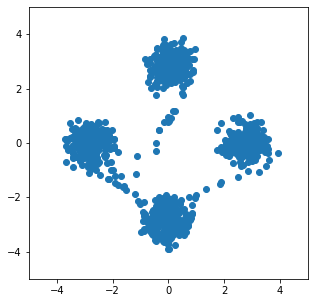

In [ ]:
test_samples_u = base_dist.sample(10000)
test_samples_x, _ = complete_forward(test_samples_u)
plot_samples_2d(test_samples_x)